In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fitsio as ft
import healpy as hp
import numpy  as np
import pandas as pd
import seaborn as sn
import sys
sys.path.append('/home/mehdi/github/LSSutils')
from LSSutils import utils
from LSSutils.catalogs.combinefits import hd5_2_fits

camb is not installed!


In [12]:
# Jan, 2020: prepare the color-box selection
# only run once 
# dr8_elg = ft.read('/home/mehdi/data/formehdi/pixweight_ar-dr8-0.32.0-elgsv.fits')
dr8_elg = ft.read('/home/mehdi/data/formehdi/pixweight_ar-dr8-0.32.0-elg-colorbox.fits')

nside   = 256 
npix    = 12*nside*nside

ss     = ['GALDEPTH_R',
          'GALDEPTH_G',
          'GALDEPTH_Z',
          'PSFSIZE_R',
          'PSFSIZE_G',
          'PSFSIZE_Z',
          'EBV',
          'STARDENS']

sysmaps = {}

sysmaps['HPIX'] = np.arange(npix)#.astype('i8')
for ss_i in ss:
    sysmaps[ss_i] = hp.reorder(dr8_elg[ss_i], n2r=True)


SV    = dr8_elg['ELG200G228']+dr8_elg['ELG228G231']+dr8_elg['ELG231G233']\
                   +dr8_elg['ELG233G234']+dr8_elg['ELG234G236']+dr8_elg['ELG200G236']

sysmaps['nran']  = hp.reorder(dr8_elg['FRACAREA'], n2r=True)
sysmaps['ngal']  = hp.reorder(SV, n2r=True) * sysmaps['nran'] * hp.nside2pixarea(256, degrees=True)

dataframe = pd.DataFrame(sysmaps)
dataframe.replace([np.inf, -np.inf], value=np.nan, inplace=True) # replace inf

dataframe.to_hdf('/home/mehdi/data/formehdi/dr8_elgsv.h5', 'data', overwrite=True)

hp.write_map('/home/mehdi/data/formehdi/dr8_elgsv_ngal.hp.256.fits', dataframe.ngal, 
         fits_IDL=False, dtype=np.float64, overwrite=True)
hp.write_map('/home/mehdi/data/formehdi/dr8_elgsv_frac.hp.256.fits', dataframe.nran, 
         fits_IDL=False, dtype=np.float64, overwrite=True)

In [13]:
# test
dataframe = pd.read_hdf('/home/mehdi/data/formehdi/dr8_elgsv.h5')
dataframe.head()

,HPIX,GALDEPTH_R,GALDEPTH_G,GALDEPTH_Z,PSFSIZE_R,PSFSIZE_G,PSFSIZE_Z,EBV,STARDENS,nran,ngal
0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1296.328125,0.0,0.0
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1220.073608,0.0,0.0
2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1448.837402,0.0,0.0
3,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1010.373413,0.0,0.0
4,4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,857.864258,0.0,0.0


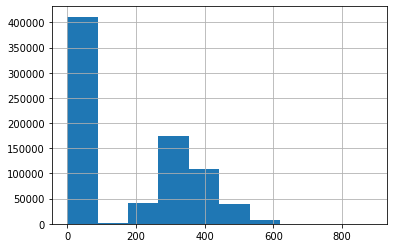

In [3]:
dataframe['ngal'].hist()

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:11

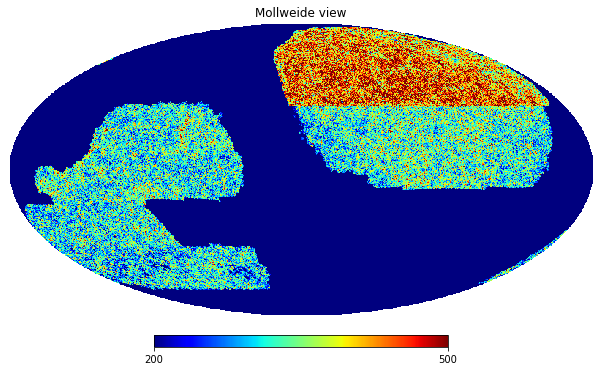

In [4]:
hp.mollview(dataframe['ngal'], min=200, max=500, 
            cmap=plt.cm.jet, rot=-89)

In [5]:
mysample = dataframe[dataframe.nran > 0.0]
decalsn, decalss, bmzls = utils.hpix2caps(mysample.HPIX.values, 
                                          nside=256)
ra, dec = utils.hpix2radec(256, mysample.HPIX.values)
decalss &= dec > -30

109492
109486
98550


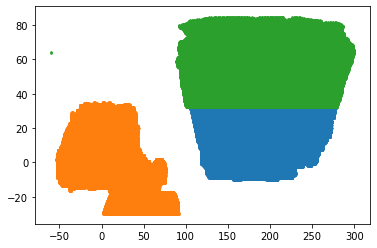

In [6]:
for i,maski in enumerate([decalsn, decalss, bmzls]):
    print(maski.sum())
    plt.scatter(utils.shiftra(ra[maski]), dec[maski], 10, marker='.')

In [7]:
mysample.loc[decalsn].shape

(109492, 11)

In [8]:
nside   = 256 

templates = ['GALDEPTH_R',
          'GALDEPTH_G',
          'GALDEPTH_Z',
          'PSFSIZE_R',
          'PSFSIZE_G',
          'PSFSIZE_Z',
          'EBV',
          'STARDENS']

for regioni, maski in zip(['bmzls', 'decaln', 'decals'],
                    [bmzls, decalsn, decalss]):
    
    mysample_i = mysample.loc[maski]
    
    print(regioni, mysample_i.shape, end=' ')
    mysample_i.dropna(inplace=True)
    print(mysample_i.shape)
    
    hd5_2_fits(mysample_i, 
               templates,  
               fitname=f'/home/mehdi/data/formehdi/dr8_elgsv_ts_{regioni}.fits',
               hpmask=f'/home/mehdi/data/formehdi/dr8_elgsv_mask_ts_{regioni}.hp.256.fits',
               hpfrac=f'/home/mehdi/data/formehdi/dr8_elgsv_frac_ts_{regioni}.hp.256.fits',
               fitnamekfold=f'/home/mehdi/data/formehdi/dr8_elgsv_ts_{regioni}_5r.npy',
               res=nside,
               k=5)

bmzls (98550, 11) (98548, 11)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_bmzls.fits


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ts_bmzls.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ts_bmzls.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_bmzls_5r.npy
decaln (109492, 11) (109488, 11)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_decaln.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ts_decaln.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ts_decaln.hp.256.fits


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_decaln_5r.npy
decals (109486, 11) (109483, 11)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_decals.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ts_decals.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ts_decals.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_ts_decals_5r.npy


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.53137593e-03 9.53182449e+01]


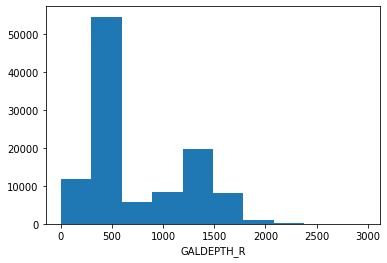

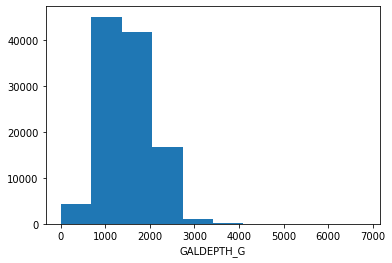

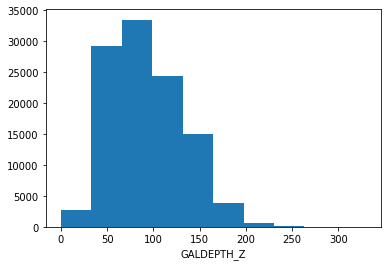

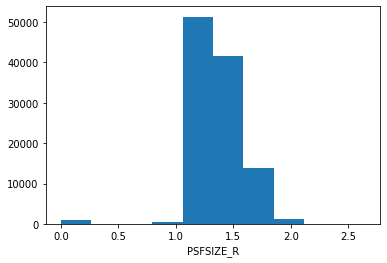

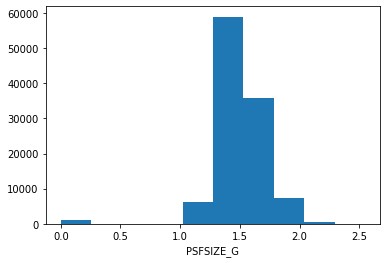

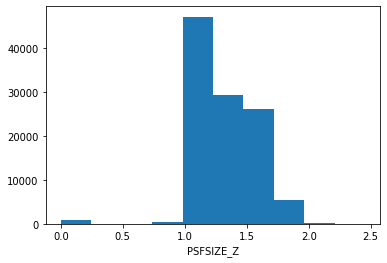

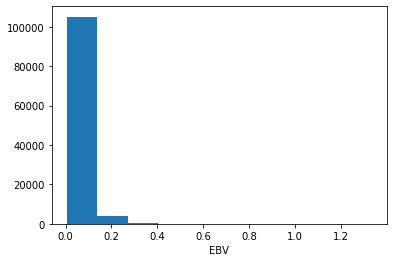

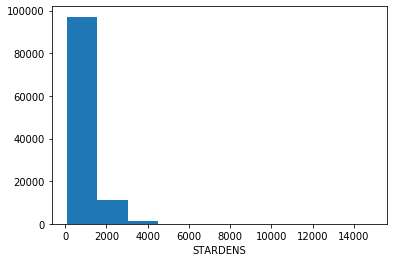

In [9]:
d = ft.read('/home/mehdi/data/formehdi/dr8_elgsv_ts_decals.fits')
print(np.min(d['features'], axis=0))
for j in range(d['features'].shape[1]):
    plt.hist(d['features'][:,j])
    plt.xlabel(templates[j])
    plt.show()

In [10]:
ls /home/mehdi/data/formehdi/

dr8_elgsv_frac_ts_bmzls.hp.256.fits   dr8_elgsv_ts_bmzls_5r.npy
dr8_elgsv_frac_ts_decaln.hp.256.fits  dr8_elgsv_ts_bmzls.fits
dr8_elgsv_frac_ts_decals.hp.256.fits  dr8_elgsv_ts_decaln_5r.npy
dr8_elgsv.h5                          dr8_elgsv_ts_decaln.fits
dr8_elgsv_mask_ts_bmzls.hp.256.fits   dr8_elgsv_ts_decals_5r.npy
dr8_elgsv_mask_ts_decaln.hp.256.fits  dr8_elgsv_ts_decals.fits
dr8_elgsv_mask_ts_decals.hp.256.fits  pixweight_ar-dr8-0.32.0-elg-colorbox.fits
dr8_elgsv_ngal.hp.256.fits            simple/


CCD templates

In [2]:
# CCD templates
dataframe = pd.read_hdf('/home/mehdi/data/dr8_combined256.h5')
dataframe.head()

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,airmass_g_mean,ccdskymag_g_mean,exptime_g_total,fwhm_g_mean,hits_g_fracdet,hits_g_total,depth_g_total,mjd_g_min,airmass_r_mean,ccdskymag_r_mean,...,ccdskymag_z_mean,exptime_z_total,fwhm_z_mean,hits_z_fracdet,hits_z_total,depth_z_total,mjd_z_min,nstar,ebv,loghi
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1296.328125,0.262538,20.807163
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1220.073608,0.259362,20.794398
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1448.837402,0.220059,20.776257
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1010.373413,0.222648,20.786459
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,857.864258,0.335517,20.811402


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:11

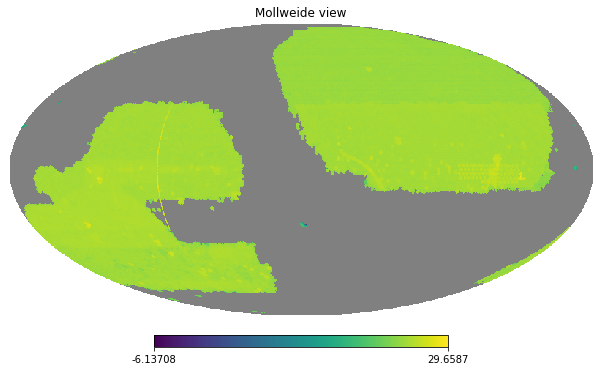

In [3]:
hp.mollview(dataframe['depth_g_total'], rot=-89)

In [4]:
ngal = hp.read_map('/home/mehdi/data/formehdi/dr8_elgsv_ngal.hp.256.fits')
frac = hp.read_map('/home/mehdi/data/formehdi/dr8_elgsv_frac.hp.256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [5]:
dataframe['ngal'] = ngal
dataframe['nran'] = frac

In [6]:
mysample = dataframe[dataframe.nran > 0.0]
decalsn, decalss, bmzls = utils.hpix2caps(mysample.index.values, 
                                          nside=256)
ra, dec = utils.hpix2radec(256, mysample.index.values)
decalss &= dec > -30

109492
109486
98550


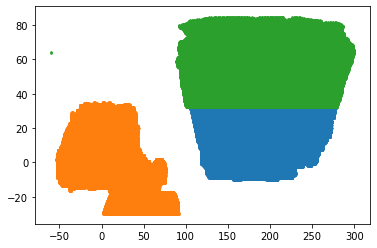

In [7]:
for i,maski in enumerate([decalsn, decalss, bmzls]):
    print(maski.sum())
    plt.scatter(utils.shiftra(ra[maski]), dec[maski], 10, marker='.')

In [8]:
mysample.loc[decalsn].shape

(109492, 29)

In [9]:
from LSSutils.catalogs.datarelease import cols_dr8
cols_dr8

['ebv',
 'loghi',
 'nstar',
 'depth_r_total',
 'depth_g_total',
 'depth_z_total',
 'fwhm_r_mean',
 'fwhm_g_mean',
 'fwhm_z_mean',
 'airmass_r_mean',
 'airmass_g_mean',
 'airmass_z_mean',
 'ccdskymag_r_mean',
 'ccdskymag_g_mean',
 'ccdskymag_z_mean',
 'exptime_r_total',
 'exptime_g_total',
 'exptime_z_total',
 'mjd_r_min',
 'mjd_g_min',
 'mjd_z_min']

In [10]:
nside   = 256 

templates = ['ebv',
             'loghi',
             'nstar',
             'depth_r_total',
             'depth_g_total',
             'depth_z_total',
             'fwhm_r_mean',
             'fwhm_g_mean',
             'fwhm_z_mean',
             'airmass_r_mean',
             'airmass_g_mean',
             'airmass_z_mean',
             'ccdskymag_r_mean',
             'ccdskymag_g_mean',
             'ccdskymag_z_mean',
             'exptime_r_total',
             'exptime_g_total',
             'exptime_z_total',
             'mjd_r_min',
             'mjd_g_min',
             'mjd_z_min']

for regioni, maski in zip(['bmzls', 'decaln', 'decals'],
                    [bmzls, decalsn, decalss]):
    
    mysample_i = mysample.loc[maski]
    
    print(regioni, mysample_i.shape, end=' ')
    mysample_i.dropna(inplace=True)
    print(mysample_i.shape)
    
    hd5_2_fits(mysample_i, 
               templates,  
               fitname=f'/home/mehdi/data/formehdi/dr8_elgsv_ccd_{regioni}.fits',
               hpmask=f'/home/mehdi/data/formehdi/dr8_elgsv_mask_ccd_{regioni}.hp.256.fits',
               hpfrac=f'/home/mehdi/data/formehdi/dr8_elgsv_frac_ccd_{regioni}.hp.256.fits',
               fitnamekfold=f'/home/mehdi/data/formehdi/dr8_elgsv_ccd_{regioni}_5r.npy',
               res=nside,
               k=5)

bmzls (98550, 29) (98223, 29)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_bmzls.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ccd_bmzls.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ccd_bmzls.hp.256.fits


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_bmzls_5r.npy
decaln (109492, 29) (109046, 29)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_decaln.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ccd_decaln.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ccd_decaln.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_decaln_5r.npy
decals (109486, 29) (108557, 29)
wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_decals.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_mask_ccd_decals.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_frac_ccd_decals.hp.256.fits
wrote /home/mehdi/data/formehdi/dr8_elgsv_ccd_decals_5r.npy


[6.28081709e-03 1.97715628e+01 0.00000000e+00 1.82588577e+01
 2.16687012e+01 2.13665733e+01 7.91670620e-01 8.98149610e-01
 7.17788696e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.75015564e+01 2.15751324e+01 1.67032661e+01 3.00000000e+01
 5.60000000e+01 7.90000000e+01 5.61841680e+04 5.61931562e+04
 5.61931523e+04]


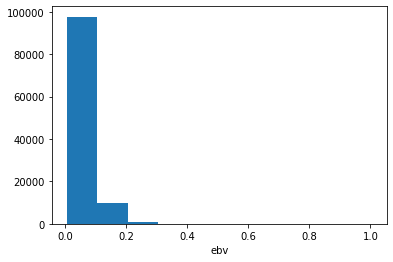

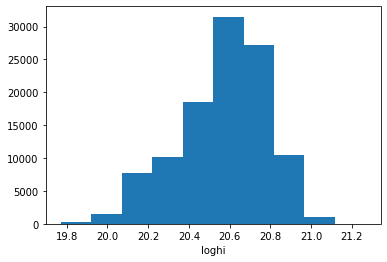

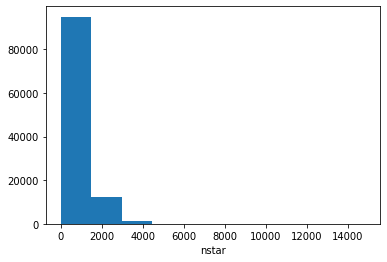

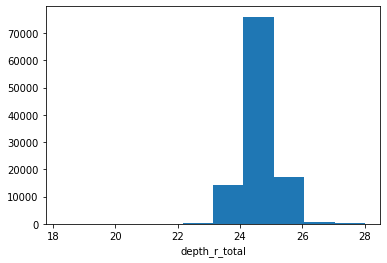

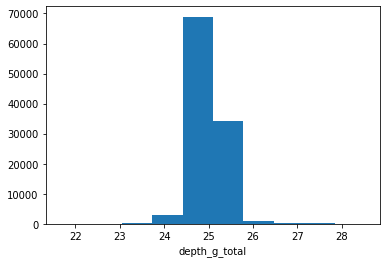

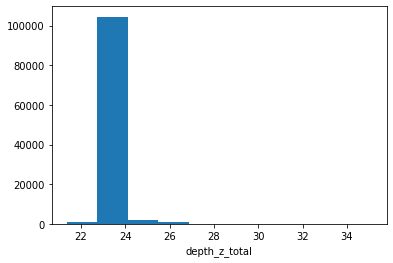

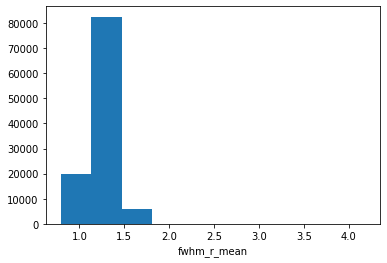

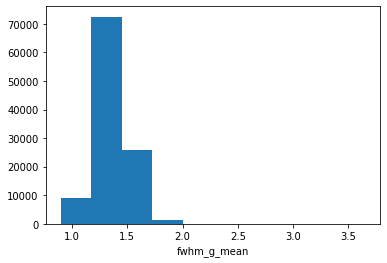

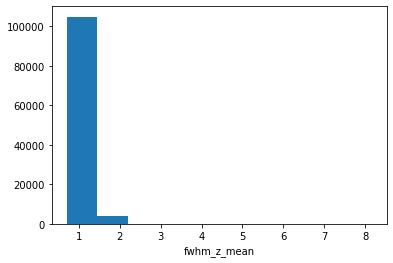

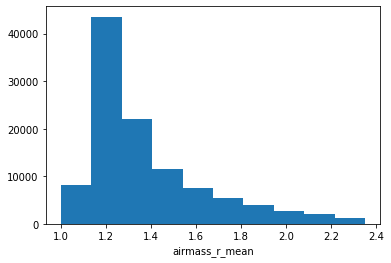

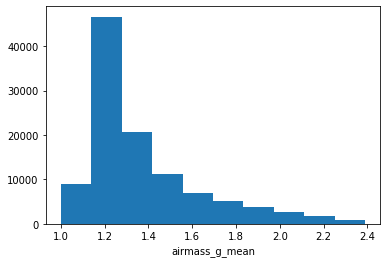

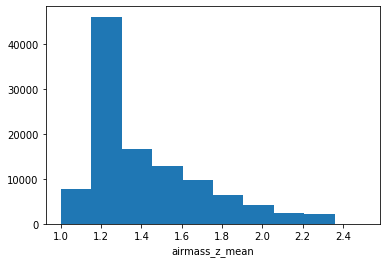

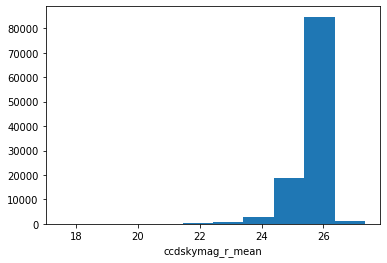

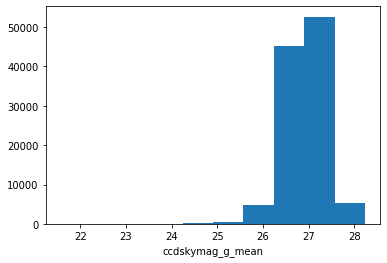

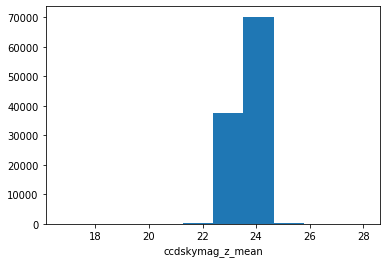

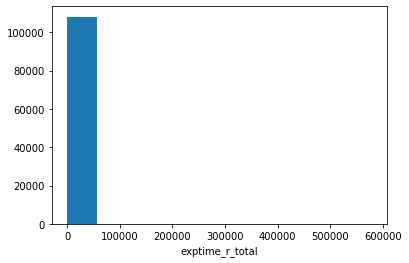

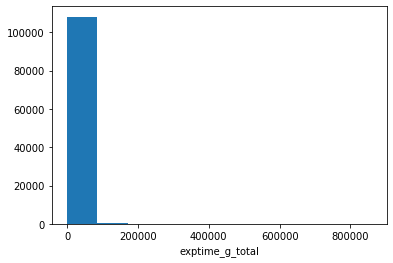

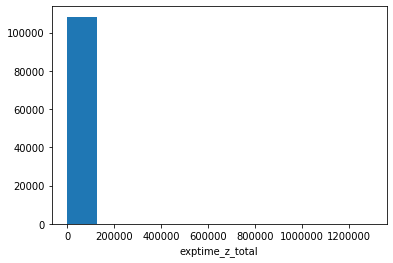

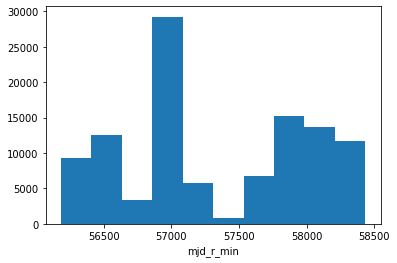

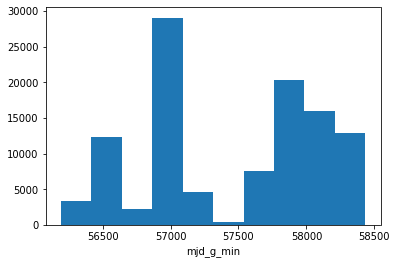

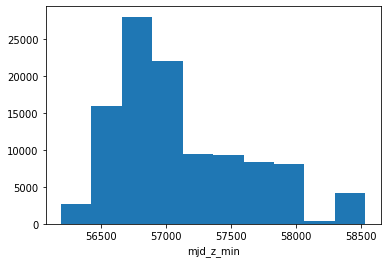

In [11]:
d = ft.read('/home/mehdi/data/formehdi/dr8_elgsv_ccd_decals.fits')
print(np.min(d['features'], axis=0))
for j in range(d['features'].shape[1]):
    plt.hist(d['features'][:,j])
    plt.xlabel(templates[j])
    plt.show()

In [3]:
ls /home/mehdi/data/formehdi/

0.4/
dr8_elgsv_ccd_bmzls_5r.npy
dr8_elgsv_ccd_bmzls.fits
dr8_elgsv_ccd_decaln_5r.npy
dr8_elgsv_ccd_decaln.fits
dr8_elgsv_ccd_decals_5r.npy
dr8_elgsv_ccd_decals.fits
dr8_elgsv_frac_ccd_bmzls.hp.256.fits
dr8_elgsv_frac_ccd_decaln.hp.256.fits
dr8_elgsv_frac_ccd_decals.hp.256.fits
dr8_elgsv_frac.hp.256.fits
dr8_elgsv_frac_ts_bmzls.hp.256.fits
dr8_elgsv_frac_ts_decaln.hp.256.fits
dr8_elgsv_frac_ts_decals.hp.256.fits
dr8_elgsv.h5
dr8_elgsv_mask_ccd_bmzls.hp.256.fits
dr8_elgsv_mask_ccd_decaln.hp.256.fits
dr8_elgsv_mask_ccd_decals.hp.256.fits
dr8_elgsv_mask_ts_bmzls.hp.256.fits
dr8_elgsv_mask_ts_decaln.hp.256.fits
dr8_elgsv_mask_ts_decals.hp.256.fits
dr8_elgsv_ngal.hp.256.fits
dr8_elgsv_ts_bmzls_5r.npy
dr8_elgsv_ts_bmzls.fits
dr8_elgsv_ts_decaln_5r.npy
dr8_elgsv_ts_decaln.fits
dr8_elgsv_ts_decals_5r.npy
dr8_elgsv_ts_decals.fits
pixweight_ar-dr8-0.32.0-elg-colorbox.fits
simple/


# plot the correlation matrices

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import fitsio as ft
import numpy as np
from glob import glob
from scipy.stats import spearmanr, pearsonr
import seaborn as sns

In [2]:
def corrmatrix(x, estimator=pearsonr):

    n, m = x.shape
    corr = np.zeros((m,m))
        
    for i in range(m):
        xi = x[:,i]
        for j in range(i, m):
            corr_ij = estimator(xi, x[:,j])[0]            
            corr[i,j] = corr_ij
            corr[j,i] = corr_ij
    return corr

def plot_corrmatrix(list_of_fits,
                    pdfname='corrmatrix_ccd.pdf',
                    templates=None):
    mpl.rcParams.update(mpl.rcParamsDefault)
    params = {
    'axes.spines.right':False,
    'axes.spines.top':False,
    'axes.labelsize': 12,
    #'text.fontsize': 8,
    'legend.fontsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': True,
    #'figure.figsize': [6, 4],
    'font.family':'serif'
    }
    plt.rcParams.update(params)
    
    # prepare the NxM matrix
    dt = []
    for fit_i in list_of_fits:
        dt_i = ft.read(fit_i)
        print(dt_i.size)
        dt.append(dt_i)
    dt = np.concatenate(dt)    
    x  = np.column_stack([dt['features'], dt['label']])
    print('reading done!')
    
    
    # compute the correlation matrices
    scorr = corrmatrix(x, estimator=spearmanr)
    print('spearman done')
    pcorr = corrmatrix(x, estimator=pearsonr)
    print('pearson done')
    
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(pdfname)
    
    for i, corr_i in enumerate([pcorr, scorr]):

        fig, ax = plt.subplots()

        mask = np.ones_like(corr_i, dtype=np.bool)
        mask[np.tril_indices_from(mask)] = False

        kw = dict(mask=mask, cmap=plt.cm.seismic, center=0, vmin=-1, vmax=1,
                  square=True, linewidths=.5, 
                  cbar_kws={"shrink": .5, "ticks":[-1, -0.5, 0, 0.5, 1]},
                  xticklabels=templates+['ngal'],
                  yticklabels=templates+['ngal'],
                  ax=ax)

        sns.heatmap(corr_i, **kw)
        pdf.savefig((i+1), bbox_inches='tight')

    pdf.close()

In [3]:
fits_ccd = glob('/home/mehdi/data/formehdi/dr8_elgsv_ccd_*.fits')
fits_ts = glob('/home/mehdi/data/formehdi/dr8_elgsv_ts_*.fits')
fits_ccd,fits_ts

(['/home/mehdi/data/formehdi/dr8_elgsv_ccd_bmzls.fits',
  '/home/mehdi/data/formehdi/dr8_elgsv_ccd_decaln.fits',
  '/home/mehdi/data/formehdi/dr8_elgsv_ccd_decals.fits'],
 ['/home/mehdi/data/formehdi/dr8_elgsv_ts_bmzls.fits',
  '/home/mehdi/data/formehdi/dr8_elgsv_ts_decaln.fits',
  '/home/mehdi/data/formehdi/dr8_elgsv_ts_decals.fits'])

In [5]:
slist = ['depth', 'fwhm', 'airmass', 'ccdskymag', 'exptime', 'mjd']
blist = ['r', 'g', 'z']

ccd = ['EBV','logHI','nstar']
ccd += ['-'.join((s, b)) for s in slist for b in blist]

ts = ['GALDEPTH-R',
      'GALDEPTH-G',
      'GALDEPTH-Z',
      'PSFSIZE-R',
      'PSFSIZE-G',
      'PSFSIZE-Z',
      'EBV',
      'STARDENS']

ccd, ts

(['EBV',
  'logHI',
  'nstar',
  'depth-r',
  'depth-g',
  'depth-z',
  'fwhm-r',
  'fwhm-g',
  'fwhm-z',
  'airmass-r',
  'airmass-g',
  'airmass-z',
  'ccdskymag-r',
  'ccdskymag-g',
  'ccdskymag-z',
  'exptime-r',
  'exptime-g',
  'exptime-z',
  'mjd-r',
  'mjd-g',
  'mjd-z'],
 ['GALDEPTH-R',
  'GALDEPTH-G',
  'GALDEPTH-Z',
  'PSFSIZE-R',
  'PSFSIZE-G',
  'PSFSIZE-Z',
  'EBV',
  'STARDENS'])

In [6]:
plot_corrmatrix(fits_ts, pdfname='corrmatrix_ts.pdf',
               templates=ts)

98548
109488
109483
reading done!
spearman done
pearson done
